In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.metrics import  confusion_matrix ,accuracy_score,classification_report
import seaborn as sns
from collections import defaultdict
import os
import operator
from tensorflow.keras.datasets import  mnist
from sklearn.preprocessing import StandardScaler

In [37]:
digits = load_digits()
data = digits.data
target = digits.target
print(data.shape,target)

(1797, 64) [0 1 2 ... 8 9 8]


In [38]:
train_x,test_x,train_y,test_y = train_test_split(data,target,train_size=0.7,test_size=None,
                                                 random_state=10,shuffle=True,stratify=None)
train_x.shape

(1257, 64)

0.987037037037037 0.987037037037037


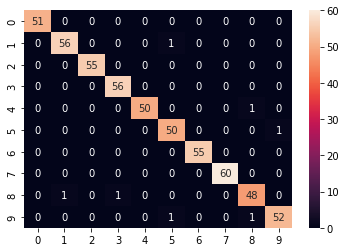

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       0.98      0.98      0.98        57
           2       1.00      1.00      1.00        55
           3       0.98      1.00      0.99        56
           4       1.00      0.98      0.99        51
           5       0.96      0.98      0.97        51
           6       1.00      1.00      1.00        55
           7       1.00      1.00      1.00        60
           8       0.96      0.96      0.96        50
           9       0.98      0.96      0.97        54

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



In [39]:
knn = KNeighborsClassifier()
knn.fit(train_x,train_y)
test_pred = knn.predict(test_x)
print(accuracy_score(test_y,test_pred),knn.score(test_x,test_y))
cm = confusion_matrix(test_y,test_pred)
df_cm = pd.DataFrame(cm,index=digits.target_names,columns=digits.target_names)
sns.heatmap(df_cm,annot=True)
plt.show()
print(classification_report(test_y,test_pred))

In [40]:
# 使用K折交叉验证
kfold = KFold(n_splits=10,random_state=10,shuffle=True)
scores = cross_val_score(estimator=knn, X=digits.data, y=digits.target,cv=kfold)
print(scores.mean())

0.9866418373680943


In [42]:
# 同时使用多个估计器
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
svm = SVC(C=1.0,kernel='rbf',degree=3,gamma='scale',class_weight=None,random_state=10)
gb = GaussianNB(priors=None,var_smoothing=1e-9)
estimator = {"KNN":knn,"SVM":svm,"GB":gb}
for key , value in estimator.items():
    kfold = KFold(n_splits=10,random_state=10,shuffle=True)
    scores = cross_val_score(estimator=value,X=digits.data, y=digits.target,cv=kfold)
    print(f"{key} : acu={scores.mean()} std={scores.std()}")

KNN : acu=0.9866418373680943 std=0.0071214707075325425
SVM : acu=0.9883147113594042 std=0.00976829828398471
GB : acu=0.8425387957790192 std=0.020066842447736086


In [44]:
# 交叉验证
cv_results = cross_validate(estimator=knn, X=digits.data, y=digits.target,cv=kfold,
               return_train_score=True,return_estimator=True)
cv_results["train_score"]

array([0.99072356, 0.98886827, 0.99072356, 0.99072356, 0.9894867 ,
       0.99010513, 0.99072356, 0.99196539, 0.99258344, 0.9907293 ])

test sample : 0
test sample : 1
test sample : 2
test sample : 3
test sample : 4
test sample : 5
test sample : 6
test sample : 7
test sample : 8
test sample : 9
test sample : 10
test sample : 11
test sample : 12
test sample : 13
test sample : 14
test sample : 15
test sample : 16
test sample : 17
test sample : 18
test sample : 19
test sample : 20
test sample : 21
test sample : 22
test sample : 23
test sample : 24
test sample : 25
test sample : 26
test sample : 27
test sample : 28
test sample : 29
test sample : 30
test sample : 31
test sample : 32
test sample : 33
test sample : 34
test sample : 35
test sample : 36
test sample : 37
test sample : 38
test sample : 39
test sample : 40
test sample : 41
test sample : 42
test sample : 43
test sample : 44
test sample : 45
test sample : 46
test sample : 47
test sample : 48
test sample : 49
test sample : 50
test sample : 51
test sample : 52
test sample : 53
test sample : 54
test sample : 55
test sample : 56
test sample : 57
test sample : 58
test sa

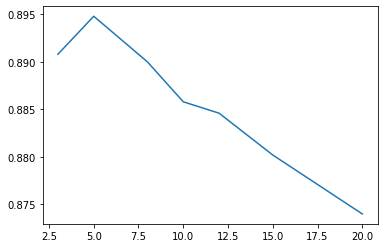

In [5]:
(train_x,train_y),(test_x,test_y)=mnist.load_data()
class Knn():
    def __init__(self,k=3,dist="L2",norm=True):
        self.k = k
        self.dist = dist
        self.norm = norm
    def process(self,data):
        data = data.reshape(-1, data.shape[1] * data.shape[2])
        if self.norm:
            scaler = StandardScaler()
            data = scaler.fit_transform(data)
        return data
    def fit(self,X_train,y_train):
        self.X_train = self.process(X_train)
        self.y_train = y_train
    def predict(self,X_test):
        # 对每个测试样本进行循环,与所有训练样本计算距离
        X_test = self.process(X_test)
        assert self.dist == 'L1' or self.dist == 'L2'  # 使用欧氏距离L2，曼哈顿距离L1
        y_test_pred = []
        from time import time
        T = time()
        for i in range(X_test.shape[0]):  # 输入的样本形状为(样本数,特征数)=(60000,784)
            current = X_test[i]  # 当前的测试样本shape=(1,784)
            current_ = np.tile(A=current, reps=(self.X_train.shape[0], 1))  # 轴0填充至60000,轴1不填充,(60000,784),但是是相同的
            if self.dist == 'L1':
                # L1 距离
                distances = np.sum(np.abs((self.X_train - current_)), axis=1)
            elif self.dist == 'L2':
                # L2 距离
                distances = np.sqrt(np.sum((self.X_train - current_) ** 2, axis=1))  # 两个行向量的列元素之间做差平方，所以axis=1,然后开根号，得到列距离矩阵
            else:
                pass
            sorted_dist_index = np.argsort(distances)  # 对所有距离升序排序并给出索引即图片序号
            nearest_k_index = sorted_dist_index[:self.k]  # 最近的k个图片的序号
            label_num = defaultdict(int)  # 统计标签的数量 key = label,value = num
            for index in nearest_k_index:
                label = self.y_train[index]  # 利用图片的标号找到图片的标签
                # k个图片标签分属不同的类别,根据投票原则需要统计每个类别的数量
                label_num[label] += 1  # 可以避免因没有key值报错,还可以自动计数
            # 字典是无序的，需要排序,使用降序,投票最多的在第1个,返回的是多个元组对象的列表
            sorted_label_num = sorted(label_num.items(), reverse=True, key=operator.itemgetter(1))
            y_test_pred.append(sorted_label_num[0][0])  # 每个测试样本投票数最多的结果的对应标签
            print(f"test sample : {i}")
        time = time() - T
        return np.array(y_test_pred),time
    def score(self,y_pred,y_true):
        score = np.sum(y_pred == y_true) / len(y_true)
        return score
# 3）不使用交叉验证
knn = Knn()
knn.fit(train_x[:5000], train_y[:5000])
pred ,time = knn.predict(test_x[:500])
print(knn.score(y_true=test_y[:500],y_pred=pred),time)
#%%
# 4）使用交叉验证
(train_x,train_y),(test_x,test_y)=mnist.load_data()
train_x,train_y = train_x[:5000], train_y[:5000]
folds = 10
ks = [3,5,8,10,12,15,20]
train_x_folds,train_y_folds = [],[]
indices = np.array_split(np.arange(train_x.shape[0]),indices_or_sections=folds)
assert len(indices) == folds # 索引拆分为10份
for indice in indices:
    train_x_folds.append(train_x[indice])
    train_y_folds.append(train_y[indice])
k_val_acu = {}
for k in ks :
    val_acu = []
    for fold in range(folds):
        print(f"k={k} fold={fold+1}")
        # 第fold折作为验证集,因为是列表所以可以使用+来拼接
        train_x_fold = train_x_folds[0:fold] + train_x_folds[fold+1:] # 长度为9的列表
        train_x_fold = np.concatenate(train_x_fold,axis=0) # 会将列表解包按行拼接
        train_y_fold = train_y_folds[0:fold] + train_y_folds[fold+1:]
        train_y_fold = np.concatenate(train_y_fold, axis=0)
        val_x_fold ,val_y_fold = train_x_folds[fold],train_y_folds[fold]
        knn = Knn(k=k)
        knn.fit(train_x_fold,train_y_fold)
        val_y_pred ,_ = knn.predict(val_x_fold)
        val_acu.append(knn.score(val_y_pred,val_y_fold))
    k_val_acu[k] = val_acu
for key , val_acu in k_val_acu.items():
    for fold , acu in enumerate(val_acu):
        print(f"k = {key} fold = {fold+1} acu = {acu}")
plt.plot(ks,[np.mean(k_val_acu[k]) for k in ks]) # 可以看出k=5最好
plt.show()